## Market Analysis (Initial)

In [1]:
import sys
import glob
import os
import re
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import numpy as np

In [2]:
# ╔═════════════════════════════╗
# ║    ✏️ VA TO EDIT            ║
# ╚═════════════════════════════╝

# client_id = "simon_20250901"
budget = [10_000, 18_000]
year = 2015                     #Newer than or equal to
odo = [50, 150]                 # Odo less than
model_short = "jazz"
model_name = "Honda Jazz"

In [3]:
import re
from datetime import datetime
import pandas as pd
from typing import Dict, Optional, List

# ---------- Constants ----------
YEAR_MIN, YEAR_MAX = 1980, 2035
ORDER: List[str] = ['href', 'year_make_model', 'trim', 'price', 'transmission', 'odometer', 'seller_type']

YEAR_RE  = r'\b(19[89]\d|20[0-3]\d)\b'
PRICE_RE = r'^\s*\$\s*[\d,]+(?:\.\d{2})?\b'
ODOM_RE  = r'^\s*\d{1,3}(?:,\d{3})+\s*km\s*$'
URL_RE   = r'^(?:https?://|www\.)'
TX, SELLER = {'automatic', 'manual'}, {'private', 'dealer used'}

THRESH: Dict[str, float] = {
    'year_make_model': 0.50,
    'price':           0.60,
    'transmission':    0.80,
    'odometer':        0.60,
    'seller_type':     0.70,
}

# ---------- Predicates ----------
def _ratio(mask: pd.Series) -> float:
    return float(mask.mean()) if len(mask) else 0.0

def _yr_ok(s: pd.Series) -> pd.Series:
    years = pd.to_numeric(s.astype(str).str.extract(YEAR_RE, expand=False), errors='coerce')
    return years.between(YEAR_MIN, YEAR_MAX)

PRED = {
    'year_make_model': lambda s: s.astype(str).pipe(_yr_ok) & s.astype(str).str.contains(r'[A-Za-z]', na=False),
    'price':           lambda s: s.astype(str).str.match(PRICE_RE, na=False),
    'transmission':    lambda s: s.astype(str).str.strip().str.lower().isin(TX),
    'odometer':        lambda s: s.astype(str).str.match(ODOM_RE, flags=re.I, na=False),
    'seller_type':     lambda s: s.astype(str).str.strip().str.lower().isin(SELLER),
}

# ---------- Core ----------
def identify_columns(df: pd.DataFrame) -> Dict[str, Optional[str]]:
    """Identify and map each canonical column."""
    cols = list(df.columns)
    if not cols:
        return {k: None for k in ORDER}

    href_col = cols[0]

    # exclude URL-like columns from other detection
    url_ratio = {c: _ratio(df[c].astype(str).str.contains(URL_RE, case=False, na=False)) for c in cols}
    urlish = {c for c, r in url_ratio.items() if r >= 0.50}
    blocked = {href_col} | urlish

    remaining = [c for c in cols if c not in blocked]
    picks = {t: None for t in PRED}

    for t in PRED:
        if not remaining:
            break
        scores = {c: _ratio(PRED[t](df[c])) for c in remaining}
        best_col, best_score = max(scores.items(), key=lambda kv: kv[1])
        if best_score >= THRESH[t]:
            picks[t] = best_col
            remaining.remove(best_col)

    trim_col = None
    ymm = picks.get('year_make_model')
    if ymm in cols:
        i = cols.index(ymm)
        if i + 1 < len(cols):
            trim_col = cols[i + 1]

    return {'href': href_col, **picks, 'trim': trim_col}

# ---------- Cleaning ----------
def clean_and_rename_cs(df: pd.DataFrame) -> pd.DataFrame:
    """Detect, rename, clean numeric/text data, and return standardized columns."""
    mapping = identify_columns(df)
    out = pd.DataFrame()

    # Map columns
    if mapping['href'] is not None:
        out['href'] = df[mapping['href']]
    for col in ['year_make_model', 'trim', 'price', 'transmission', 'odometer', 'seller_type']:
        src = mapping.get(col)
        if src is not None:
            out[col] = df[src]

    # Split "year make model"
    if 'year_make_model' in out.columns:
        split_cols = out['year_make_model'].astype(str).str.split(expand=True, n=2)
        split_cols.columns = ['year', 'make', 'model']
        out = pd.concat([out, split_cols], axis=1)

    # Clean hrefs (remove query strings)
    if 'href' in out.columns:
        out['href'] = out['href'].astype(str).str.split('?').str[0]

    # Clean numeric columns
    for col in ['price', 'odometer']:
        if col in out.columns:
            out[col] = (
                out[col].astype(str)
                .replace('[^\\d]', '', regex=True)
                .replace('', pd.NA)
                .astype(float)
                .astype('Int64')
            )

    # Convert odometer to thousands of km
    if 'odometer' in out.columns:
        out['odometer'] = out['odometer'] // 1000

    # Add scrape date
    out['date_scraped'] = datetime.today().date()

    # Build final tidy table
    final_cols = ['href', 'year', 'make', 'model', 'price', 'trim', 'odometer', 'seller_type', 'date_scraped']
    return out[[c for c in final_cols if c in out.columns]]

In [7]:
# Reading all carsales csvs
# path = os.path.join(os.getcwd(), client_id)
path = ""
files = glob.glob(os.path.join(path, "carsales*.csv"))
cs = pd.concat([clean_and_rename_cs(pd.read_csv(f)) for f in files], ignore_index=True)

# Dropping duplicates
cs['href'] = cs['href'].astype(str)
before = len(cs)
cs = cs.drop_duplicates(subset=['href'], keep='first')
print(f"Dropped {before - len(cs)} duplicate rows.")


cs.head(5)

# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║
# ╚═════════════════════════════╝
# 1. Text Roger if duplicate rows > 0
# 2. Sense check each column

Dropped 0 duplicate rows.


,href,year,make,model,price,trim,odometer,seller_type,date_scraped
0,https://www.carsales.com.au/cars/details/2019-...,2019,Honda,Jazz,15888,VTi Auto F MY20,81,Private,2025-10-16
1,https://www.carsales.com.au/cars/details/2018-...,2018,Honda,Jazz,17888,VTi Auto F MY19,70,Private,2025-10-16
2,https://www.carsales.com.au/cars/details/2017-...,2017,Honda,Jazz,15990,VTi Auto F MY17,82,Private,2025-10-16
3,https://www.carsales.com.au/cars/details/2017-...,2017,Honda,Jazz,15995,VTi-S Auto F MY18,68,Private,2025-10-16
4,https://www.carsales.com.au/cars/details/2016-...,2016,Honda,Jazz,12900,VTi Auto F MY17,132,Private,2025-10-16


In [11]:
def clean_fb(df):
    # Split the b column into 'year', 'make', 'model'
    df[['year', 'make', 'model']] = df['b'].str.split(expand=True, n=2)

    # Rename columns
    rename_columns = {
        "x1i10hfl href": "href",
        "a": "price",
        "c": "location",
        "d": "odometer",
    }
    df.rename(columns=rename_columns, inplace=True)

    # removing query string
    df["href"] = df['href'].str.split('?').str[0]

    # Convert price and odometer columns to integers
    df=df[df['price']!="Free"]
    df['price'] = df['price'].replace(r'[^\d]', '', regex=True).astype(float).astype('Int64')
    df['odometer'] = df['odometer'].replace(r'[^\d]', '', regex=True).astype(float).astype('Int64')

    # Add a column with today's date
    df['date_scraped'] = datetime.today().date()

    # Removing listings with null values
    df = df.dropna(subset=["price","odometer","year"])

    # Select only the required columns in order
    final_columns = ['href', 'year', 'make', 'model', 'price', 'odometer', 'location', 'date_scraped']
    df = df[final_columns]
    return df

In [12]:
files = glob.glob(os.path.join(path, "facebook*.csv"))
fb = pd.concat([clean_fb(pd.read_csv(f)) for f in files], ignore_index=True)

fb['href'] = fb['href'].astype(str)
before = len(fb)
print(f"Rows starting {len(fb)}.")
fb = fb.drop_duplicates(subset=['href'], keep='first')
print(f"Rows remaining {len(fb)}.")

fb.head(5)

# ╔═════════════════════════════╗
# ║    🔎 VA TO CHECK OUTPUT    ║
# ╚═════════════════════════════╝
# 1. Check that number of rows remaining is approximately files*40
# 2. Sense check each column

Rows starting 24.
Rows remaining 24.


,href,year,make,model,price,odometer,location,date_scraped
0,https://www.facebook.com/marketplace/item/1322...,2019,Honda,jazz,17000,85,"Sydney, NSW",2025-10-16
1,https://www.facebook.com/marketplace/item/1432...,2016,Honda,jazz,17800,45,"Sydney, NSW",2025-10-16
2,https://www.facebook.com/marketplace/item/1188...,2015,Honda,jazz,11900,154,"Sydney, NSW",2025-10-16
3,https://www.facebook.com/marketplace/item/1358...,2019,Honda,jazz,18500,49,"Sydney, NSW",2025-10-16
4,https://www.facebook.com/marketplace/item/1112...,2015,Honda,jazz,13900,140,"Sydney, NSW",2025-10-16


In [21]:
df = cs
df = pd.concat([cs, fb], ignore_index=True)

# Remove duplicates for cars in both carsales/fb marketplace
print(f"Rows starting {len(df)}.")
df=df.drop_duplicates(subset=['year', 'price', 'odometer'])
print(f"Rows remaining {len(df)}.")

# Save file
# df.to_csv(f"{path}/{model_short}_all.csv", index=False)
df.to_csv(f"all.csv")

Rows starting 34.
Rows remaining 33.


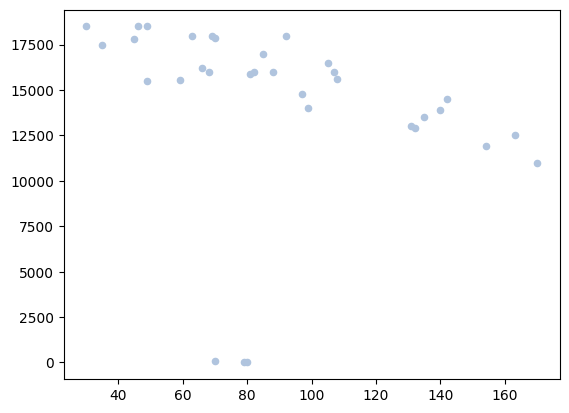

In [14]:
plt.scatter(df['odometer'], df['price'], label='Data', color='lightsteelblue', s=20)

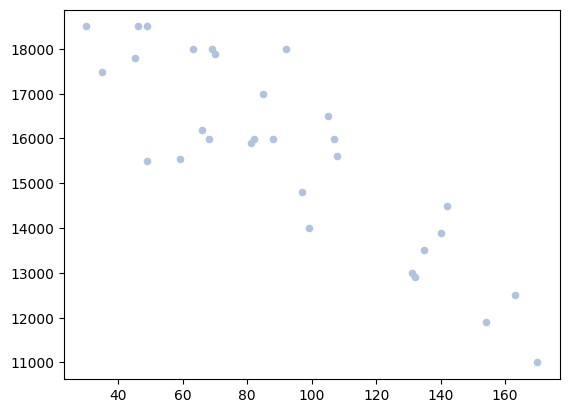

In [15]:
# ╔═════════════════════════════╗
# ║    ✏️ VA TO EDIT            ║
# ╚═════════════════════════════╝

# Removing listings with unrealistic low price
# Code keeps cars with price>X
df1 = df[df["price"]>5000]

# Remove listings with high odometer
# Code keeps cars with odo<X
df1 = df1[df1["odometer"]<250]

# Remove listings with unrealistic low odometer
# Code keeps cars with odo>X
df1 = df1[df1["odometer"]>0]
plt.scatter(df1['odometer'], df1['price'], label='Data', color='lightsteelblue', s=20)

In [16]:
# 0) Work on a real copy (kills SettingWithCopyWarning)
df1 = df1.copy()

# Truncate at 250,000km
df1 = df1[df1["odometer"]<250]

# 1) Coerce to numeric (allow bad cells to become NaN)
df1['year']     = pd.to_numeric(df1['year'], errors='coerce')
df1['odometer'] = pd.to_numeric(df1['odometer'], errors='coerce')
df1['price']    = pd.to_numeric(df1['price'], errors='coerce')

# 2) Build X, y as float and drop rows with NaNs
X_num = df1[['year','odometer']].astype(float)
y_num = df1['price'].astype(float)
keep  = X_num.notna().all(axis=1) & y_num.notna()

X = sm.add_constant(X_num.loc[keep])
y = y_num.loc[keep]

# Optional sanity checks
assert np.isfinite(X.to_numpy()).all() and np.isfinite(y.to_numpy()).all()
assert X[['year','odometer']].std().gt(0).all()

# 3) Fit and predict
model = sm.OLS(y, X).fit()
print(model.summary())

df1.loc[keep, 'predicted_price'] = model.predict(X)
df1.loc[keep, 'value_diff'] = df1.loc[keep, 'predicted_price'] - df1.loc[keep, 'price']

print(f"Used {keep.sum()} rows; dropped {len(df1) - keep.sum()} rows.")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     59.88
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           1.19e-10
Time:                        05:30:04   Log-Likelihood:                -246.39
No. Observations:                  30   AIC:                             498.8
Df Residuals:                      27   BIC:                             503.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.336e+05   2.54e+05     -2.891      0.0

In [17]:
# Identify n best value cars
within_crit = df1[
    (df1["price"]<budget[1]) & (df1['price']>budget[0])
    & (df1['year']>=year)
    & (df1['odometer']<odo[1]) & (df1['odometer']>odo[0])
]

In [18]:
# Rank the top-n best-value cars (1 = best)
best_n = within_crit.sort_values('value_diff', ascending=False).head(10).copy()
best_n['rank'] = np.arange(1, len(best_n) + 1)

other_listings = df1.merge(best_n, how="outer", indicator=True) \
          .query('_merge == "left_only"') \
          .drop(columns="_merge")

In [19]:
for _, row in best_n.iterrows():
    print(f"Car {row['rank']}")
    print(f"Link: {row['href']}")
    print(f"Price: ${row['price']:,}")
    print(f"Market Value: ${row['predicted_price']:,.0f}")
    print(f"Year: {row['year']}")
    print(f"Odometer: {row['odometer']:,.0f},000km\n")


# ╔═════════════════════════════╗
# ║     VA TO SAVE 💾           ║
# ╚═════════════════════════════╝
# Paste in Google Docs
# clients/client_name [tab: Market Analysis]

Car 1
Link: https://www.facebook.com/marketplace/item/1983400949140329/
Price: $15,550
Market Value: $17,166
Year: 2017
Odometer: 59,000km

Car 2
Link: https://www.carsales.com.au/cars/details/2019-honda-jazz-vti-auto-my20/SSE-AD-19592172/
Price: $15,888
Market Value: $16,991
Year: 2019
Odometer: 81,000km

Car 3
Link: https://www.carsales.com.au/cars/details/2016-honda-jazz-vti-auto-my17/SSE-AD-17017941/
Price: $12,900
Market Value: $13,734
Year: 2016
Odometer: 132,000km

Car 4
Link: https://www.carsales.com.au/cars/details/2017-honda-jazz-vti-s-auto-my18/SSE-AD-17535370/
Price: $15,995
Market Value: $16,789
Year: 2017
Odometer: 68,000km

Car 5
Link: https://www.carsales.com.au/cars/details/2015-honda-jazz-vti-s-auto-my15/SSE-AD-18976307/
Price: $14,000
Market Value: $14,743
Year: 2015
Odometer: 99,000km

Car 6
Link: https://www.facebook.com/marketplace/item/755696710372281/
Price: $13,000
Market Value: $13,403
Year: 2015
Odometer: 131,000km

Car 7
Link: https://www.carsales.com.au/car

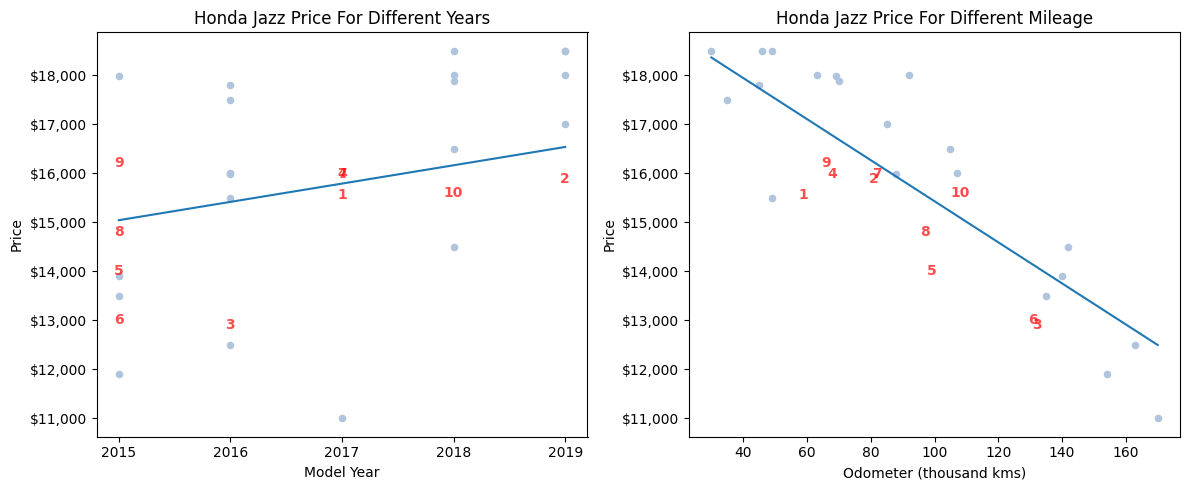

In [20]:
# Function to format price axis
def price_format(x, _):
    return f'${int(x):,}'

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter (Year vs Price)
ax1.scatter(other_listings['year'], other_listings['price'], label='Data', color='lightsteelblue', s=20)

for _, row in best_n.iterrows():
    ax1.scatter(row['year'], row['price'], s=70, facecolors='none',  linewidths=1.2)
    ax1.text(row['year'], row['price'], str(int(row['rank'])),
             ha='center', va='center', fontsize=10, fontweight='bold', color='red', alpha = 0.7
#              bbox=dict(boxstyle='round,pad=0', fc='white', ec='none')
            )

# Regression line (fix odometer at mean)
year_range = np.linspace(other_listings['year'].min(), other_listings['year'].max(), 100)
mean_odometer = other_listings['odometer'].mean()
X_line = pd.DataFrame({
    'const': 1,
    'year': year_range,
    'odometer': [mean_odometer]*100
})
y_line = model.predict(X_line)
ax1.plot(year_range, y_line, label='Regression line')

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.yaxis.set_major_formatter(FuncFormatter(price_format))
ax1.set_xlabel('Model Year')
ax1.set_ylabel('Price')
ax1.set_title(f"{model_name} Price For Different Years")

# Scatter (Odometer vs Price)
ax2.scatter(other_listings['odometer'], other_listings['price'], label='Data', color='lightsteelblue', s=20)

for _, row in best_n.iterrows():
    ax2.scatter(row['odometer'], row['price'], s=70, facecolors='none',  linewidths=1.2)
    ax2.text(row['odometer'], row['price'], str(int(row['rank'])),
             ha='center', va='center', fontsize=10, fontweight='bold', color='red', alpha = 0.7
#              bbox=dict(boxstyle='round,pad=0', fc='white', ec='none')
            )

# Regression line (fix year at mean)
odometer_range = np.linspace(other_listings['odometer'].min(), other_listings['odometer'].max(), 100)
mean_year = other_listings['year'].mean()
X_line2 = pd.DataFrame({
    'const': 1,
    'year': [mean_year]*100,
    'odometer': odometer_range
})
y_line2 = model.predict(X_line2)
ax2.plot(odometer_range, y_line2, label='Regression line')

ax2.yaxis.set_major_formatter(FuncFormatter(price_format))
ax2.set_xlabel('Odometer (thousand kms)')
ax2.set_ylabel('Price')
ax2.set_title(f"{model_name} Price For Different Mileage")

plt.tight_layout()
plt.show()


# ╔═════════════════════════════╗
# ║     VA TO SAVE 💾           ║
# ╚═════════════════════════════╝
# Paste in Google Docs
# clients/client_name [tab: Market Analysis]